## Lab 13.b -- Crime Stats



In [2]:
import json
import os

print(os.getcwd())

##
with open("../data/Victoria (BC) Police Department.geojson") as f:
    data = json.loads(f.read())
    

/home/rybu/teaching/math248/mp248-planning/Labs


In [3]:
import collections as co
import pprint as pp

ctree = dict()

for R in data['features']:
    TopI = R['properties']['parent_incident_type']
    BotI = R['properties']['incident_type_primary']
    if TopI not in ctree.keys():
        ctree[TopI] = co.defaultdict(int)
    ctree[TopI][BotI] += 1
    
pp.pprint(ctree)


{'Alarm': defaultdict(<class 'int'>, {'FALSE ALARMS': 1447}),
 'Arson': defaultdict(<class 'int'>,
                      {'ARSON-DISREGARD FOR HUMAN LIFE': 22,
                       'ARSON-PROPERTY': 260}),
 'Assault': defaultdict(<class 'int'>,
                        {'ASSAULT AGAINST POLICE OFFICER': 417,
                         'ASSAULT-COMMON OR TRESPASS': 2065,
                         'ASSAULTS-OTHER': 473}),
 'Assault with Deadly Weapon': defaultdict(<class 'int'>,
                                           {'ASSAULT OT P/O-W/WPN OR CBH': 38,
                                            'ASSAULT POLICE-W/WEAPON OR CBH': 75,
                                            'ASSAULT-AGGRAVATED': 98,
                                            'ASSAULT-OTHER PEACE OFFICER': 125,
                                            'ASSAULT-W/WEAPON OR CBH': 1552}),
 'Breaking & Entering': defaultdict(<class 'int'>,
                                    {'BREAK & ENTER-BUSINESS': 1691,
          

In [4]:
import datetime as dt

clean_dat = list()
incompl_dat = list()

for x in data['features']:
    if 'properties' not in x.keys():
        continue ## why bother?

    ## we have the properties, so let's start building the record.
    newRec = dict()
    incFlag = False # set to true if we discover missing data in x
    
    floatkeys = ['latitude', 'longitude']
    strkeys = ['parent_incident_type', 'incident_type_primary', 'address_1', 'address_2']
    intkeys = ['case_number', 'incident_id']
    datekeys = ['created_at', 'updated_at', 'incident_datetime']
    
    for k in floatkeys:
        if k in x['properties'].keys() and isinstance(x['properties'][k], str) and\
        len(x['properties'][k])>0:
            newRec[k] = float(x['properties'][k])
        else:
            incFlag=True

    ## anything to check?
    for k in strkeys:
        newRec[k] = x['properties'][k]
        
    for k in intkeys:
        ## let's count non-numerical characters
        non_ch_chars = []
        digits = '0123456789'
        for ch in x['properties'][k]:
            if ch not in digits:
                non_ch_chars.append(ch)

        for ch in non_ch_chars:
            if ch != '-':
                x['properties'][k] = x['properties'][k].replace(ch, '-')
            
        if '-' in x['properties'][k]:
            newRec[k] = [int(w) for w in x['properties'][k].split('-')]
        else:
            newRec[k] = int(x['properties'][k])
            
    for k in datekeys:
        ## typical format: '2014-12-06T21:59:00.000'
        newRec[k] = dt.datetime.strptime(x['properties'][k], '%Y-%m-%dT%H:%M:%S.000')
        
    if incFlag:
        incompl_dat.append(newRec)
    else:
        clean_dat.append(newRec)

In [5]:
## Let's use the results from the lab earlier this week to fix or purge the clearly bad data from
## clean_dat...

bad_idx = []

for i in range(len(clean_dat)):
    x = clean_dat[i]
    if x['latitude']>48.655 or x['latitude']<48:
        bad_idx.append(i)
        continue
    if x['longitude']<-124 or x['longitude']>-123:
        bad_idx.append(i)
        continue
    if x['incident_datetime'] > x['created_at']:
        bad_idx.append(i)
        continue
    if x['updated_at'] < x['created_at']:
        bad_idx.append(i)
print("Original number of records in clean_dat: ", len(clean_dat))
print("Bad records discovered: ", len(bad_idx))

clean_dat = [clean_dat[i] for i in range(len(clean_dat)) if i not in bad_idx]
print("Purged clean_dat: ", len(clean_dat))

Original number of records in clean_dat:  129094
Bad records discovered:  1426
Purged clean_dat:  127668


**Problem 1:** Write a Python function that uses spherical polar coordinates to determine the distance "as the crow flies" between any two points on the earth's surface.  The function will take as input two points, given in spherical polar coordinates, i.e. *longitude* and *latitude*. Assume your points are on the earth's surface, and that the earth is a sphere of radius **6378**km. 

As a sanity check, find the GPS coordinates of two points on the earth for which you know the distance "as the crow flies".  Compute their distance using your function, and compare.

In [6]:
import numpy as np

Re = 6378000 ## let's use metres.

def PC(lat, long):
    return np.array([np.cos(long)*np.cos(lat), np.sin(long)*np.cos(lat), np.sin(lat)])

## this will be our distance function
## it takes the two coordinates, finds the corresponding points on the surface of the earth (at ocean level)
## then finds the angle between them, i.e. arccos(v1.v2) and multiplies by the radius Re.
def dA(lat1, long1, lat2, long2):
    lat1 *= np.pi/180
    lat2 *= np.pi/180
    long1 *= np.pi/180
    long2 *= np.pi/180
    
    p1 = PC(lat1, long1)
    p2 = PC(lat2, long2)
    cosang = sum(p1*p2)
    
    return(Re*np.arccos(cosang))
    
## lat, long for London England 51.52, -0.24
## lat, long for Victoria BC    48.43, -123.38 
print(dA(51.52, -0.24, 48.43, -123.38)/1000)
## This is essentially what Google tells us. 

7670.053653805334


**Problem 2:** Find the longitude and latitude of *The Bay Centre* in downtown Victoria. *Hint:* If you zoom in on something in Google maps, the longitude and latitude should appear in the address bar.  If this does not happen in your browser, try the *share* option. 

In [7]:
## Appears to be 48.42505, -123.36647
BClat = 48.42505
BClong = -123.36647


**Problem 3:** If we use the GPS coordinates of the Bay Centre as a proxy for the *centre of downtown Victoria*, what relation is there between the quantity of Victoria PD crime records and their distance to the centre of downtown?   One way to answer this problem would be to build a histogram where the x-axis is the distance to downtown, and the y-axis is the crime count.  Perhaps choose your bin size so that all your bins have equal area. 


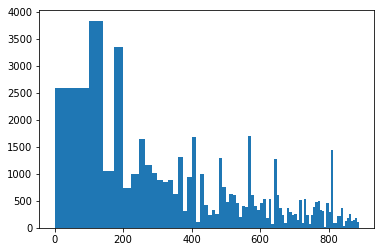

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

X = [dA(BClat, BClong, x['latitude'], x['longitude']) for x in clean_dat]
A = plt.hist(X, bins=[100*np.sqrt(k) for k in range(80)])
## it appears the "crime centre" is about 100m from the Bay Centre, but otherwise things are
## mostly close to downtown.

**Problem 4:** Compute the latitude and longitude of the average position of all the crimes in **clean_dat**. Look up that location in Google Maps.  How would you describe it, is it a store, or perhaps its in the middle of a street?
    

In [9]:
V = sum([PC(x['latitude']*np.pi/180, x['longitude']*np.pi/180) for x in clean_dat])
V = V/np.linalg.norm(V)
print(V)

[-0.36493434 -0.55415623  0.7481536 ]


In [14]:
clat = 180*np.arcsin(V[2])/np.pi
planar = np.array([V[0], V[1], 0])
planar = planar/np.linalg.norm(planar)
clong = -180*np.arccos(sum(planar*np.array([1,0,0])))/np.pi

print("Latitude: ", clat)
print("Longitude: ", clong )

Latitude:  48.430688823698354
Longitude:  -123.36652404549156


In [15]:
## This appears to be right in the centre of the Fountain Tire shop on Herald st. 

**Problem 5:** Repeat Problem 3, but using the answer to Problem 4 as your centre.

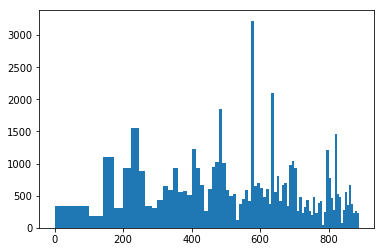

In [18]:
X = [dA(clat, clong, x['latitude'], x['longitude']) for x in clean_dat]
A = plt.hist(X, bins=[100*np.sqrt(k) for k in range(80)])

So while it appears the rough vicinity of the Bay Centre is where the bulk of crimes occur, it is displaced significantly from the average location of crimes.  